# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:**Nereida Heller

*Semester:* Fall 2024

FYI explanatory links in PDF are all deadends. I constructed a dataset through extensive googling and vlookup. It's in my repo, feel free to save it for future classes!

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [3]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

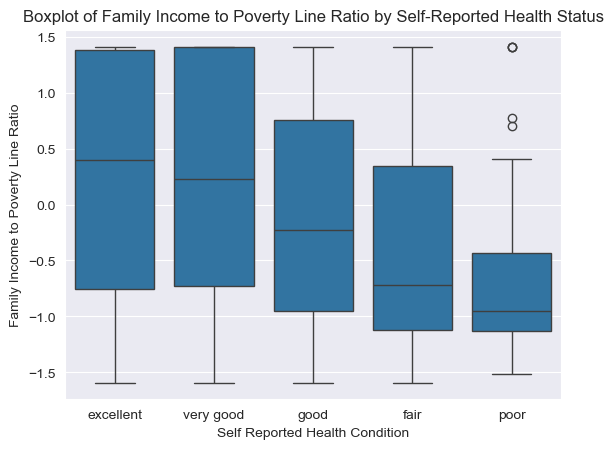

In [4]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

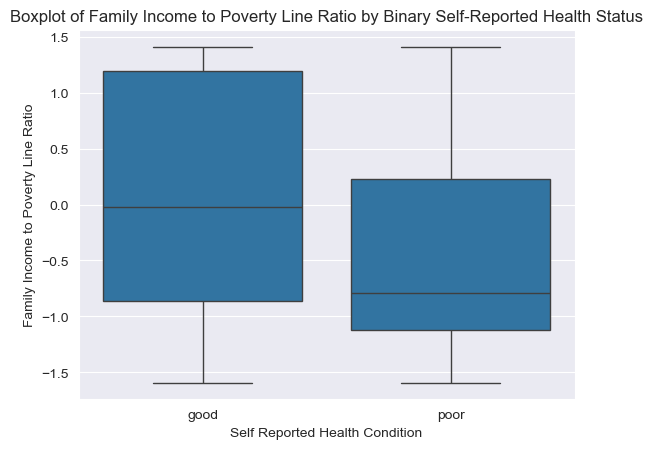

In [5]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

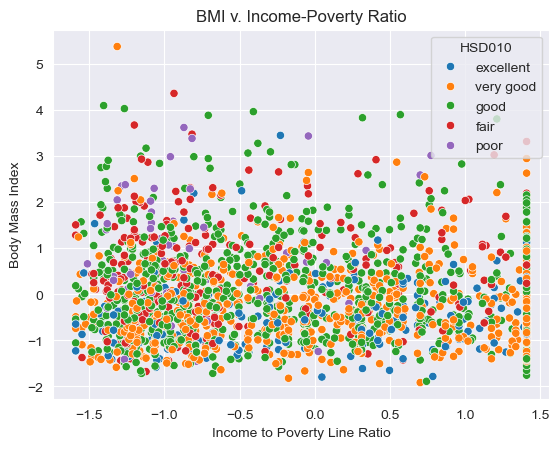

In [6]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [7]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

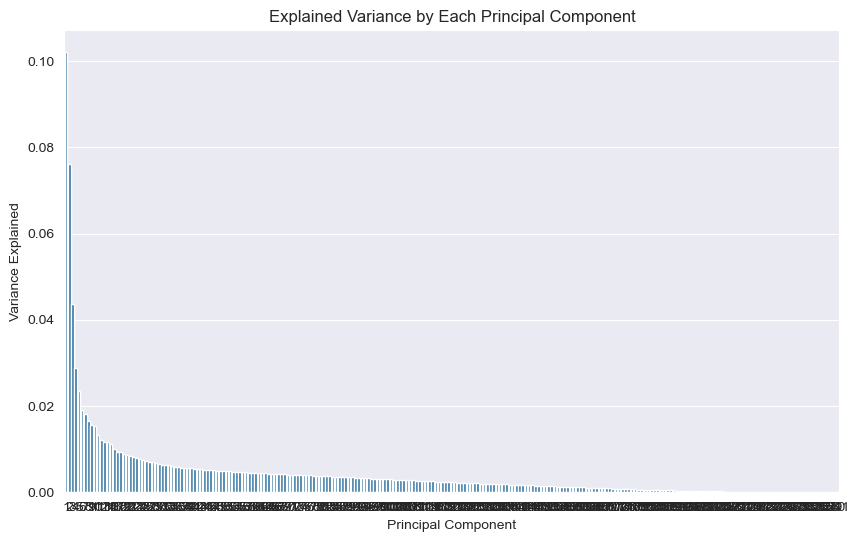

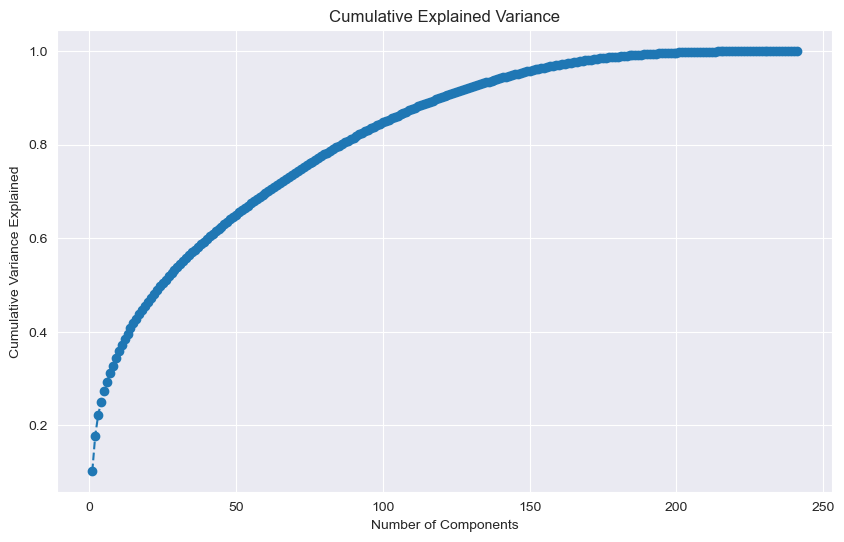

Number of components chosen: 86


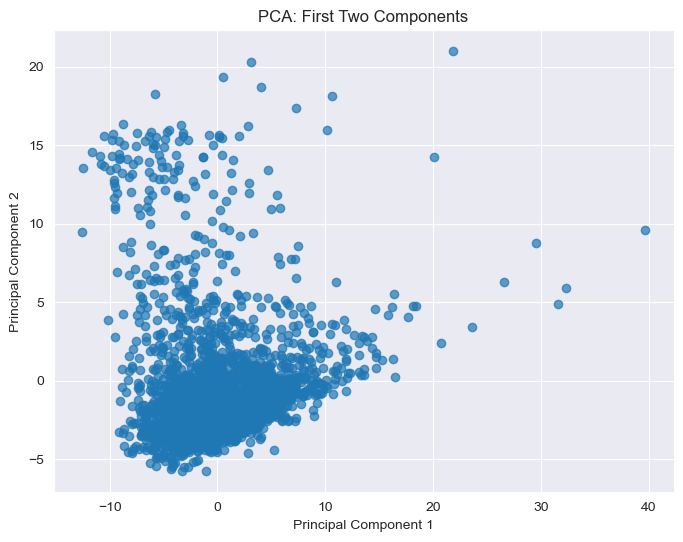

In [8]:
## Your Answer Here

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Assuming nhanes_scaled is already defined

# 1. Fit PCA and choose the number of components
pca = PCA()
pca.fit(nhanes_scaled)

# Cumulative explained variance to help choose number of components
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# 2. Plot the explained variance for each component
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(1, len(pca.explained_variance_ratio_) + 1), 
            y=pca.explained_variance_ratio_)
plt.title('Explained Variance by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# Plot the cumulative explained variance to choose the number of components
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.show()

# 3. Choose number of components based on cumulative variance (e.g., 80% variance)
num_components = np.argmax(explained_variance >= 0.80) + 1
print(f"Number of components chosen: {num_components}")

# 4. Plot a 2D scatterplot of the first two components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(nhanes_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
plt.title('PCA: First Two Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### Barplot of Components

In [8]:
## Your Answer Here

### How many components will you use to fit a supervised learning model?

In [ ]:
## Your Answer Here

### 2D Scatterplot of the first two components

In [ ]:
## Your Answer Here

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.p

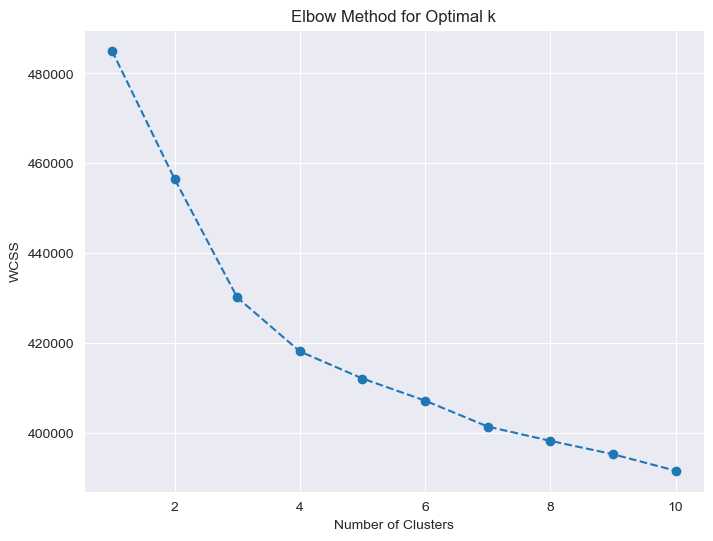

C:\Users\mackgsr1nvivo\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# 2.1 Elbow method to determine optimal k
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(nhanes_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# 2.2 Based on the plot, choose the number of clusters (e.g., k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(nhanes_scaled)
labels = kmeans.labels_

# 3. Plot clusters on BMI vs. Income Poverty Ratio
# Assuming 'BMI' and 'Income Pov


### Cluster nhanes

In [ ]:
## Your Answer Here

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [ ]:
## Your Answer Here

## Your Answer Here

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [ ]:
## Your Answer Here

## Your Answer Here

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features -- my code

In [13]:
#cgpt1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Assuming 'HSD010_binary' is the target variable
# X = nhanes_scaled.drop(columns=['HSD010_binary'])  # Drop target variable
# y = nhanes_scaled['HSD010_binary']
X = nhanes_scaled
y = 'HSD010_binary'


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the neural network
nn_original = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
nn_original.fit(X_train, y_train)

# Evaluate the model
y_pred_original = nn_original.predict(X_test)
print("Neural Network using Original Features:")
print(classification_report(y_test, y_pred_original))


ValueError: Found input variables with inconsistent numbers of samples: [2064, 13]

In [11]:
#cgpt2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Assuming 'HSD010_binary' is the target variable
X = nhanes_scaled.drop(columns=['HSD010_binary'])  # Drop target variable
y = nhanes_scaled['HSD010_binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the neural network
nn_original = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
nn_original.fit(X_train, y_train)

# Evaluate the model
y_pred_original = nn_original.predict(X_test)
print("Neural Network using Original Features:")
print(classification_report(y_test, y_pred_original))


KeyError: "['HSD010_binary'] not found in axis"

In [ ]:
#cgpt3
# Train PCA with 2 components (you can adjust the number of components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Split the data into training and testing sets
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Create and train the neural network
nn_pca = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
nn_pca.fit(X_train_pca, y_train)

# Evaluate the model
y_pred_pca = nn_pca.predict(X_test_pca)
print("Neural Network using PCA Components:")
print(classification_report(y_test, y_pred_pca))


In [12]:
#cgpt4
# Predict cluster labels using the previously trained K-means model
kmeans_labels = kmeans.predict(X)

# Combine PCA components and cluster labels
X_pca_clustered = np.hstack([X_pca, kmeans_labels.reshape(-1, 1)])

# Split the data into training and testing sets
X_train_pca_clustered, X_test_pca_clustered, y_train, y_test = train_test_split(X_pca_clustered, y, test_size=0.2, random_state=42)

# Create and train the neural network
nn_pca_clustered = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
nn_pca_clustered.fit(X_train_pca_clustered, y_train)

# Evaluate the model
y_pred_pca_clustered = nn_pca_clustered.predict(X_test_pca_clustered)
print("Neural Network using PCA Components and Cluster Membership:")
print(classification_report(y_test, y_pred_pca_clustered))


NameError: name 'X' is not defined

In [14]:
### Neural Network on Original Features -- class prompts

In [ ]:
# partition data
# -----------
y = ... # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = ... # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [ ]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = ...
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(..., ...)
y_test = keras.utils.to_categorical(..., ...)
num_classes = y_test.shape[1]

In [ ]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(..., input_dim= ..., kernel_initializer= ..., activation= ...))

model.add(Dense(..., kernel_initializer= ..., activation= ...))

## Add any additional layers you wish here

model.compile(loss= ..., optimizer= ..., metrics=[...])

model.fit(..., ..., validation_data=(..., ...), epochs=..., batch_size=..., verbose=...)

### Neural Network on Principal Components

In [ ]:
## Your Answer Here

### Neural Network on Principal Components + Cluster Membership

In [ ]:
## Your Answer Here

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

Principal Component Analysis (PCA) is a technique to reduce dimensionality, shrinking the data down to the most important parts. By reducing the number of features in the data to the principal components, PCA makes it easier to process and understand. Clustering is also a simplifying technique but  instead of reductions it simplifies by sorting data into groups of similar things, finding which features go together, and identifying patterns or groupings. PCA simplifies the data by reducing its complexity, while clustering identifies patterns or groupings within the it.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques like PCA and clustering help with supervised learning by reducing noise, simplifying data structures, and creating new features that capture key patterns. This kind of preprocessing makes it easier for supervised algorithms to be trained and to perform well, especially when the raw data is messy, highly dimensional, or overwhelming in size. Unsupervised techniques can give supervised models a clearer roadmap to follow. For instance, clustering can reveal underlying patterns  by grouping similar datapoints, creating more meaningful labels for supervised analyses. 